In [116]:
import xarray as xr
import nowpp
import numpy as np
import dask as da
import scipy.stats as stats
import time
import pandas as pd
import cartopy.crs as ccrs
import seaborn as sns
from datetime import date
import cmclimate as cmc
from matplotlib import pyplot as plt
from dask.distributed import LocalCluster, Client
from cartopy import config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cluster = LocalCluster(processes=False, local_dir= "/g/data1a/e14/rm6294/dask-workers")
client = Client(cluster)
client

Client Scheduler: inproc://10.0.64.17/17601/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 8 Memory: 33.67 GB


In [118]:
# Plotting stuff
plt.rcParams["figure.figsize"] = [16,9]
sns.set()

In [9]:
# Defining chunk sizes
x_chunk = 30
y_chunk = 40
t_chunk = 365

In [10]:
# Importing MHW observation files
localDir = "/g/data1a/e14/rm6294/matlab_trial/"
# Want obs from lon: 90 to 210, lat: (+- ?)10 to -50 (not sure if I should go to +10 or -10)
mhws = xr.open_mfdataset(localDir + 'mhw_severity.pc90.*-50to-30*.nc')['severity']
mhws = mhws.sel(time = slice('1990-01-01', '2008-12-31'))
mhws = mhws.chunk({'time' : t_chunk, 'lat' : y_chunk, 'lon' : x_chunk})

/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [11]:
# Importing MHW model files
localDir = "/g/data1a/e14/rm6294/NOWMHW/"
pastMHW = xr.open_dataarray(localDir + 'mhws_NOWPastRun.nc')
pastMHW = pastMHW.isel(y = slice(5,120), x = slice(110, 330))
pastMHW = pastMHW.chunk({'x' : x_chunk, 'y' : y_chunk, 'time_counter' : t_chunk})

## SST standard deviation 

In [99]:
localDir = "/g/data1a/e14/rm6294/NOWMHW/"
pClim = xr.open_dataarray(localDir + 'pastClimRep.nc')
sst_dir = '/g/data1a/e14/gs9353/NOW_OUTPUTS/'
sstPast = xr.open_zarr(sst_dir + 'now_cordex24_BMJv2_BILAP_old/cordex24-BMJv2_BILAP_1d_1990_2008_grid_T_2D.zarr')['tos'].sel(simulation = 'Present')
mod_ssta = sstPast.isel(x = slice(110,330), y = slice(5,120)).chunk({'x': x_chunk, 'y':y_chunk, 'time_counter':t_chunk}) - pClim.isel(x = slice(110,330), y = slice(5,120)).chunk({'x': x_chunk, 'y':y_chunk, 'time_counter':t_chunk})
mod_ssta['nav_lon'] = mod_ssta['nav_lon']  % 360 

In [129]:
localDir = "/g/data1a/e14/rm6294/matlab_trial/"
obs_ssta = xr.open_mfdataset(localDir + 'mhw_severity.pc90.*-50to-30*.nc')['ssta']
obs_ssta = obs_ssta.sel(time = slice('1990-01-01', '2008-12-31'))
obs_ssta = obs_ssta.chunk({'time' : t_chunk, 'lat' : y_chunk, 'lon' : x_chunk})

/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


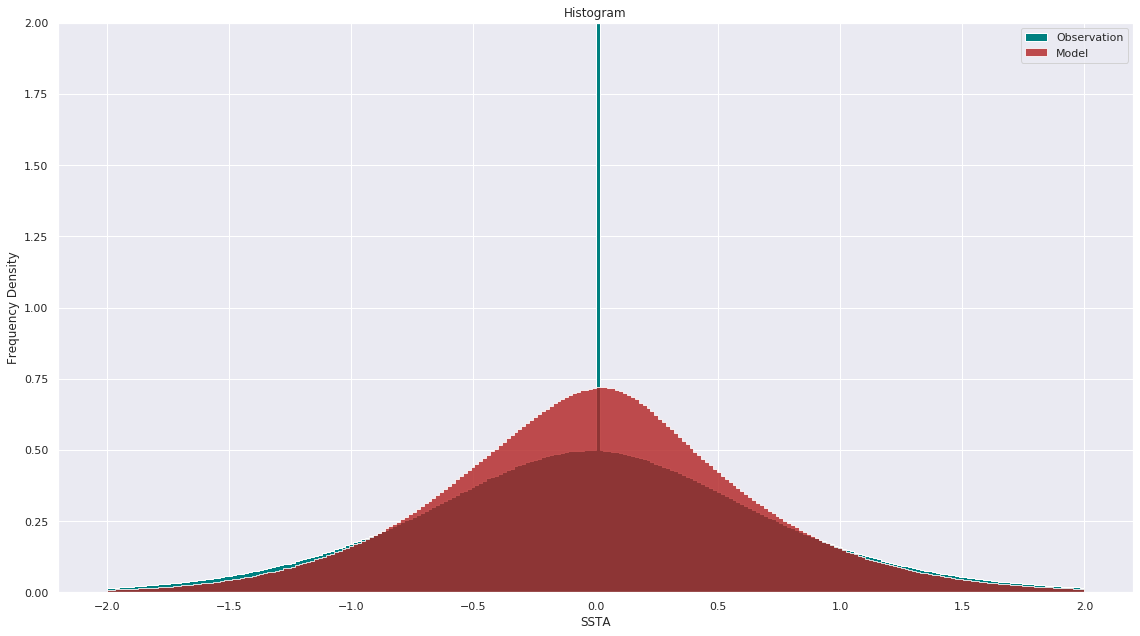

In [180]:
bins = linspace(-2.0, 2.0, 251)
obs_ssta.plot.hist(bins = bins, density = True, histtype='stepfilled', color = 'teal', label = 'Observation');
mod_ssta.plot.hist(bins = bins, density = True, histtype='stepfilled', color = 'firebrick', alpha = 0.8,  label = 'Model');
plt.ylim(0,2)
plt.legend()
plt.ylabel('Frequency Density')
plt.xlabel('SSTA')
plt.tight_layout()

In [130]:
mod_std = mod_ssta.std(dim = 'time_counter').compute().chunk({'x' : x_chunk, 'y' : y_chunk})
obs_std = obs_ssta.std(dim = 'time').compute().chunk({'lat' : y_chunk, 'lon' : x_chunk})

/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [131]:
mod_std = xr.where(mod_std == 0, np.nan, mod_std)
obs_std = xr.where(obs_std == 0, np.nan, obs_std)

/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


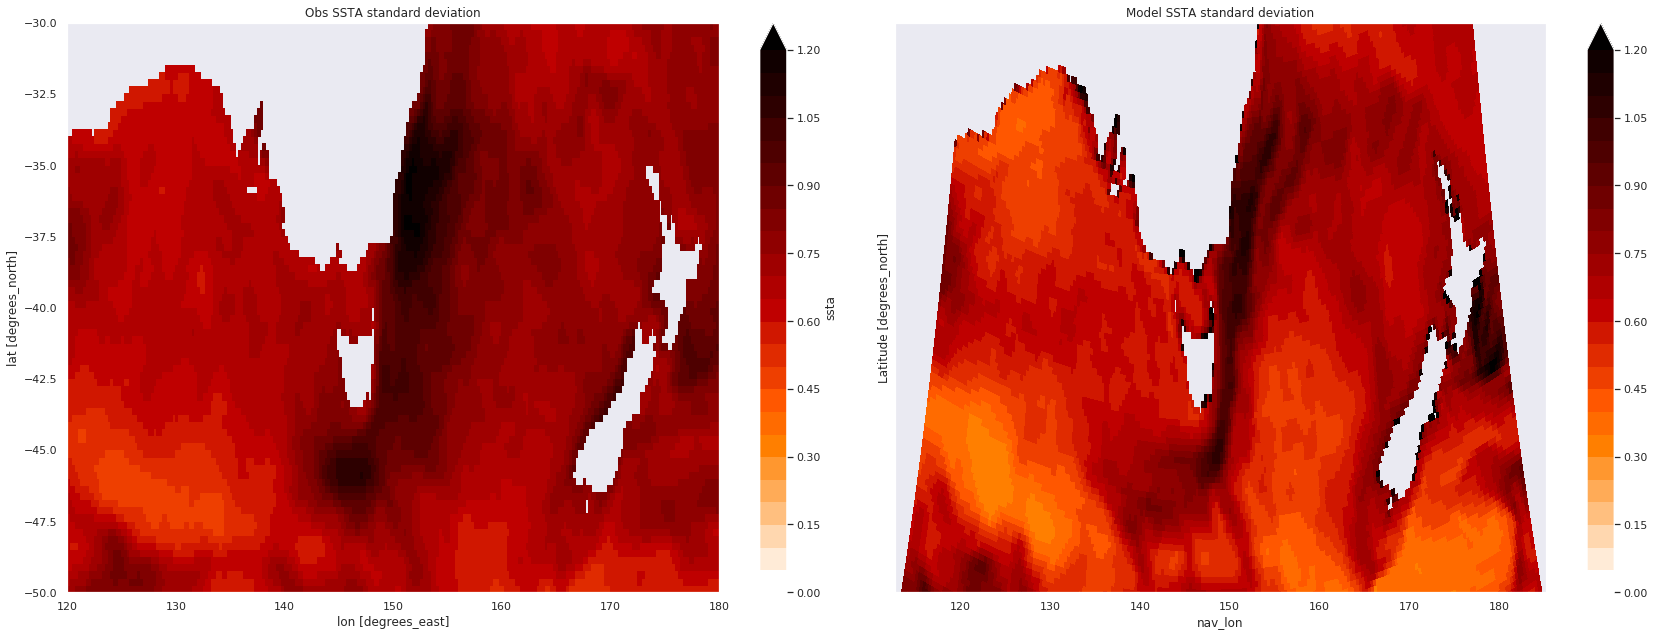

In [151]:
fig, axes = plt.subplots(ncols = 2, figsize = [24, 9], sharey = True)
vmax = 1.2
cmap_temp = cmc.cm.MPL_gist_heat_r
levels = linspace(0, vmax, vmax * 20 + 1)
obs_std.plot(ax = axes[0], cmap = cmap_temp, levels = levels, vmax = vmax);
axes[0].set_title('Obs SSTA standard deviation')
mod_std.plot(ax = axes[1], x = 'nav_lon', y = 'nav_lat', cmap = cmap_temp, vmax = vmax, levels = levels);
axes[1].set_title('Model SSTA standard deviation')
plt.tight_layout()
#plt.savefig('/home/561/rm6294/Documents/tas_ssta_std.png')

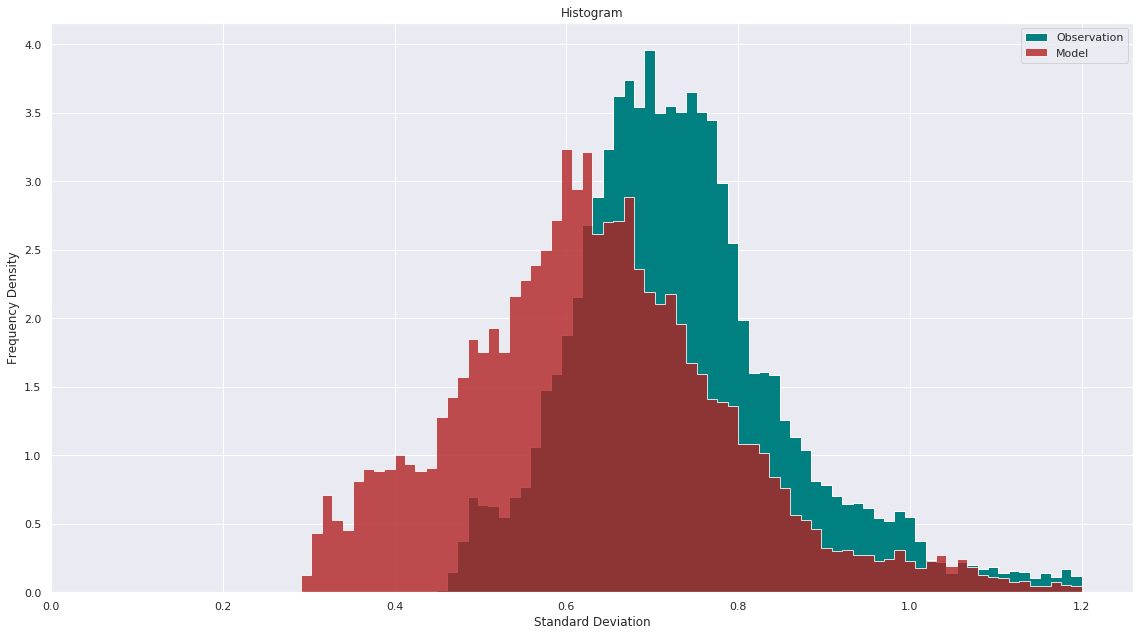

In [164]:
bins = linspace(0, 1.2, 100)
obs_std.plot.hist(bins = bins, density = True, histtype='stepfilled', color = 'teal', label = 'Observation');
mod_std.plot.hist(bins = bins, density = True, histtype='stepfilled', color = 'firebrick', alpha = 0.8,  label = 'Model');
plt.xlim(0,)
plt.legend()
plt.ylabel('Frequency Density')
plt.xlabel('Standard Deviation')
plt.tight_layout()
#plt.savefig('/home/561/rm6294/Documents/tas_ssta_std_hist.png')

In [169]:
print(('Model Tasmanian region \u03C3 = {0:.4}').format(mod_ssta.std().compute().data))
print(('Observation Tasmanian region \u03C3 = {0:.4}').format(obs_ssta.std().compute().data))

Model Tasmanian region σ = 0.6554
Observation Tasmanian region σ = 0.6857


In [69]:
mean_mod_lat = mod_std.mean(dim = 'x')
max_mod_lat = mod_std.max(dim = 'x') 
min_mod_lat = mod_std.min(dim = 'x')

In [70]:
mean_obs_lat = obs_std.mean(dim = 'lon')
max_obs_lat = obs_std.max(dim = 'lon') 
min_obs_lat = obs_std.min(dim = 'lon')

/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/dask/compatibility.py:107: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/dask/compatibility.py:107: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/dask/compatibility.py:107: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/pytho

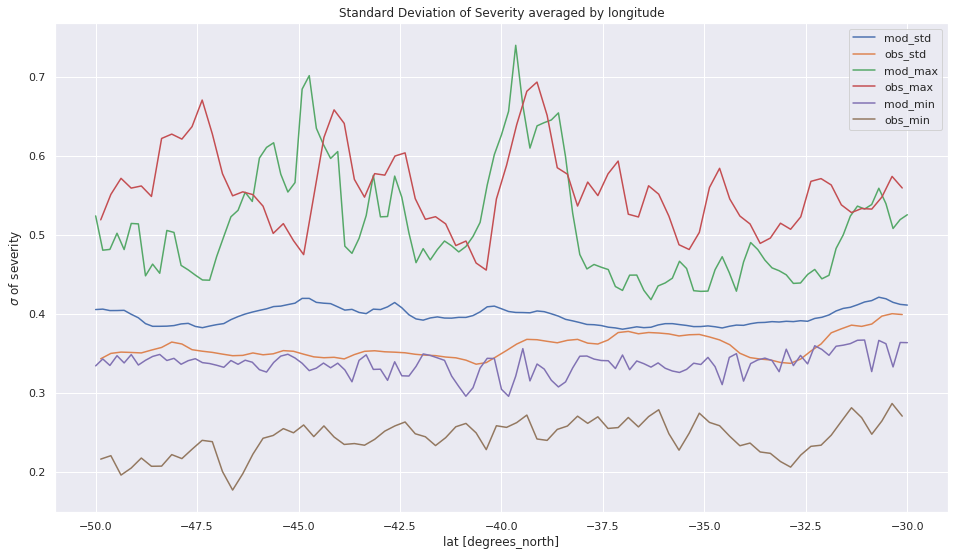

In [82]:
plt.plot(linspace(-50,-30, 115),  mean_mod_lat.data, label = 'mod_std');
mean_obs_lat.plot(label = 'obs_std');
plt.plot(linspace(-50,-30, 115),  max_mod_lat.data, label = 'mod_max');
max_obs_lat.plot(label = 'obs_max');
plt.plot(linspace(-50,-30, 115),  min_mod_lat.data, label = 'mod_min');
min_obs_lat.plot(label = 'obs_min');
plt.ylabel('$\sigma$ of severity')
plt.title('Standard Deviation of Severity averaged by longitude')
plt.legend();

## Finding mean of the max severity per year in model and observational MHWs
This removes the edges of the model, which are known to be inaccurate. Additonally I removed an extra amount from the top of the model, which seemed to give some weird results.

In [7]:
maxSev = mhws.groupby('time.year').max(dim = 'time').mean(dim = 'year').compute()

# Replaces land masses with nan as opposed to 0 value
maxSev = xr.where(maxSev == 0, np.nan, maxSev)

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


In [9]:
# Same as above
maxPastSev = pastMHW.groupby('time_counter.year').max(dim = 'time_counter').mean(dim = 'year').compute()

maxPastSev = xr.where(maxPastSev == 0, np.nan, maxPastSev)

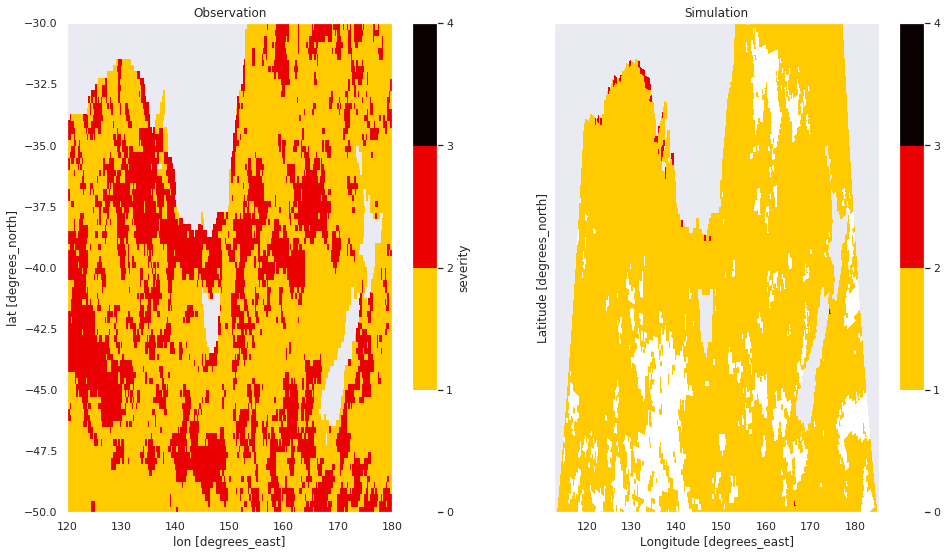

In [97]:
f, ax = plt.subplots(1, 2, sharey = True)
vmin = 0; vmax = 3;
level = arange(0,5)
maxSev.plot(cmap = 'hot_r', vmin = vmin, vmax = vmax, ax = ax[0], levels = level);
maxPastSev.plot(cmap = 'hot_r', vmin = vmin, vmax = vmax, ax = ax[1], x = 'nav_lon', y = 'nav_lat', levels = level);
ax[0].set_title('Observation')
ax[1].set_title('Simulation');

### Histogram

In [11]:
y1 = np.linspace(0,1.9)
y2 = np.linspace(0,3)

# Calculates the median for simulation
median_sim = maxPastSev.median().data
# Creates a time series that can be used alongside a histogram to show the change in median
median_series_sim = np.full_like(y1, median_sim)

# Calculates the median for observations
median_obvs = maxSev.median().data
# Creates a time series that can be used alongside a histogram to show the change in median
median_series_obvs = np.full_like(y2, median_obvs)

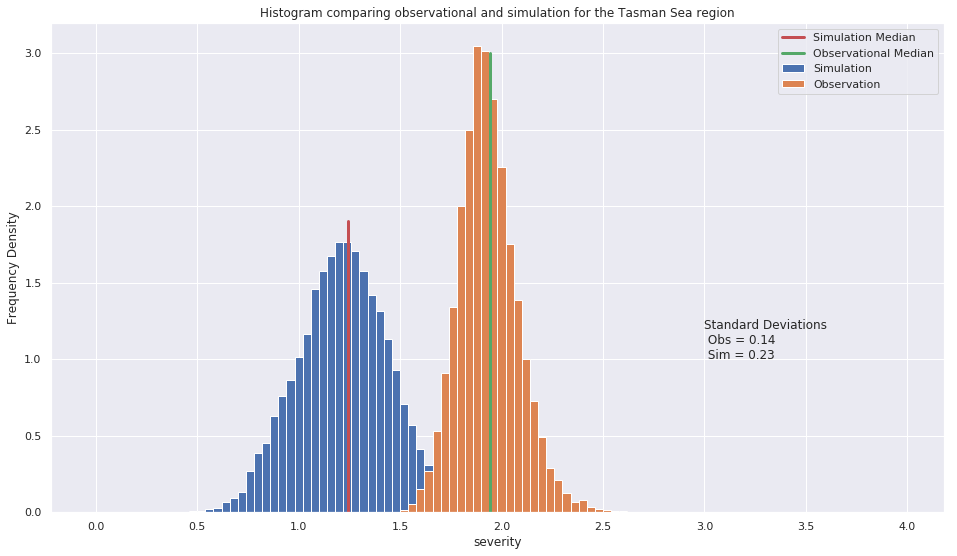

In [12]:
# Plots the frequencies/frequency density for each severity. 
bins = np.linspace(0,4,101)
# True if plotting densities, false if you want just frequency
pltDens = True

maxPastSev.plot.hist(align = 'left', bins = bins, density = pltDens, label = 'Simulation')
maxSev.plot.hist(align = 'left', bins = bins, density = pltDens, label = 'Observation')

plt.plot(median_series_sim, y1, 'r',label = 'Simulation Median', linewidth = 3)
plt.plot(median_series_obvs, y2, 'g',label = 'Observational Median', linewidth = 3)

plt.title('Histogram comparing observational and simulation for the Tasman Sea region')
plt.ylabel('Frequency Density')
plt.legend()

std_obvs = np.round(maxSev.std().data,2)
std_sim = np.round(maxPastSev.std().data,2)
std_str = ('Standard Deviations\n Obs = {0:.2} \n Sim = {1:.2}').format(std_obvs, std_sim)
plt.text(3.0, 1, std_str);

## Comparing climatologies and thresholds

In [22]:
obs_clim = xr.open_mfdataset('/g/data1a/e14/rm6294/matlab_trial/mhw_severity.pc90.*-50to-30*.nc')['climatology']
obs_thresh = xr.open_mfdataset('/g/data1a/e14/rm6294/matlab_trial/mhw_severity.pc90.*-50to-30*.nc')['climatology90']

In [84]:
obs_clim_mean = obs_clim.mean(dim = ['lat', 'lon'])
obs_thresh_mean = obs_thresh.mean(dim = ['lat', 'lon'])

In [88]:
mod_clim = xr.open_dataarray('/g/data1a/e14/rm6294/NOWMHW/pastClimRep.nc').chunk({'x' : x_chunk, 'y' : y_chunk, 'time_counter' : t_chunk})
mod_thresh = xr.open_dataarray('/g/data1a/e14/rm6294/NOWMHW/pastThreshRep.nc').chunk({'x' : x_chunk, 'y' : y_chunk, 'time_counter' : t_chunk})

In [98]:
mod_clim_mean = mod_clim.isel(y = slice(5,120), x = slice(110, 330), time_counter = slice(0,365)).mean(dim = ['x', 'y'])
mod_thresh_mean = mod_thresh.isel(y = slice(5,120), x = slice(110, 330), time_counter = slice(0,365)).mean(dim = ['x', 'y'])

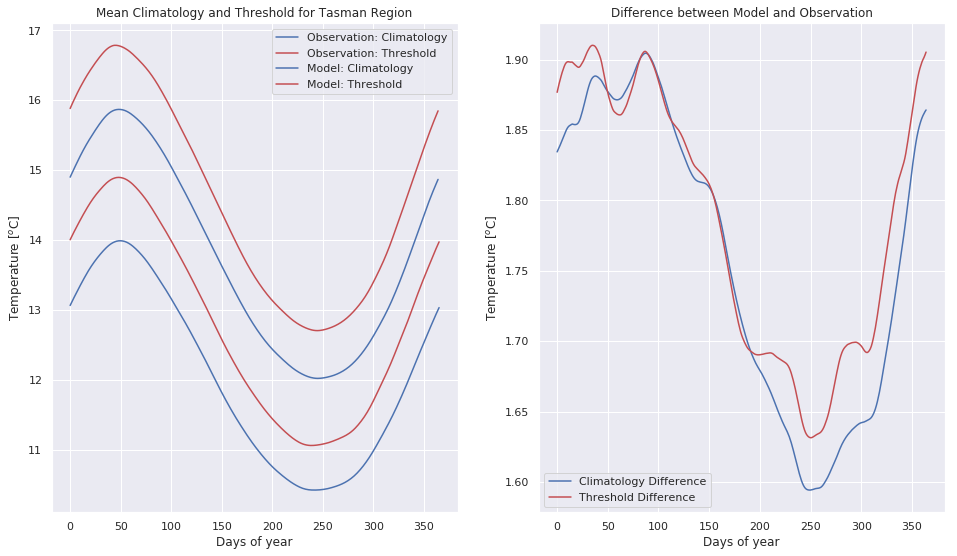

In [148]:
fig, axes = plt.subplots(ncols = 2)

axes[0].plot(obs_clim_mean.data, label = 'Observation: Climatology')
axes[0].plot(obs_thresh_mean.data, 'r', label = 'Observation: Threshold');
axes[0].plot(mod_clim_mean.data, 'b', label = 'Model: Climatology')
axes[0].plot(mod_thresh_mean.data, 'r', label = 'Model: Threshold');
axes[0].set_xlabel('Days of year')
axes[0].set_ylabel('Temperature [$^o$C]')
axes[0].set_title('Mean Climatology and Threshold for Tasman Region')
axes[0].legend();

axes[1].plot(mod_clim_mean.data - obs_clim_mean.data[:-1], label = 'Climatology Difference')
axes[1].plot(mod_thresh_mean.data - obs_thresh_mean.data[:-1], 'r', label = 'Threshold Difference')
axes[1].set_xlabel('Days of year')
axes[1].set_ylabel('Temperature [$^o$C]')
axes[1].set_title('Difference between Model and Observation')
axes[1].legend();

plt.savefig('/home/561/rm6294/Documents/model_clim_comparison.png')

## Severity standard deviation 

In [30]:
mod_std = pastMHW.std(dim = 'time_counter').compute().chunk({'x' : x_chunk, 'y' : y_chunk})
obs_std = mhws.std(dim = 'time').compute().chunk({'lat' : y_chunk, 'lon' : x_chunk})

/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [58]:
mod_std = xr.where(mod_std == 0, np.nan, mod_std)
obs_std = xr.where(obs_std == 0, np.nan, obs_std)

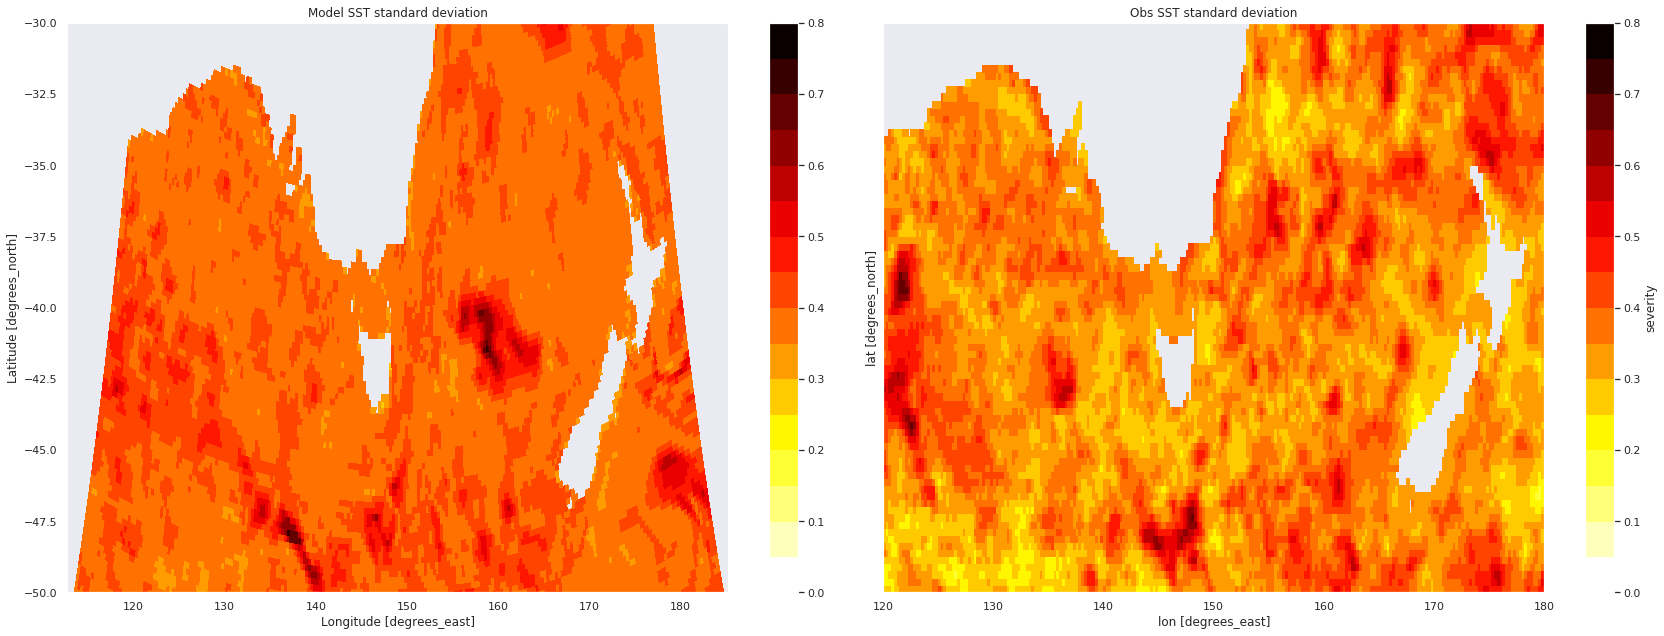

In [59]:
fig, axes = plt.subplots(ncols = 2, figsize = [24, 9], sharey = True)
vmax = 0.8
levels = linspace(0, 0.8, 17)
mod_std.plot(ax = axes[0], vmax = vmax, x = 'nav_lon', y = 'nav_lat', cmap = 'hot_r', levels = levels);
axes[0].set_title('Model SST standard deviation')
obs_std.plot(ax = axes[1], vmax = vmax, cmap = 'hot_r', levels = levels);
axes[1].set_title('Obs Severity standard deviation')
plt.tight_layout()

In [69]:
mean_mod_lat = mod_std.mean(dim = 'x')
max_mod_lat = mod_std.max(dim = 'x') 
min_mod_lat = mod_std.min(dim = 'x')

In [70]:
mean_obs_lat = obs_std.mean(dim = 'lon')
max_obs_lat = obs_std.max(dim = 'lon') 
min_obs_lat = obs_std.min(dim = 'lon')

/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/dask/compatibility.py:107: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/dask/compatibility.py:107: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/dask/compatibility.py:107: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/pytho

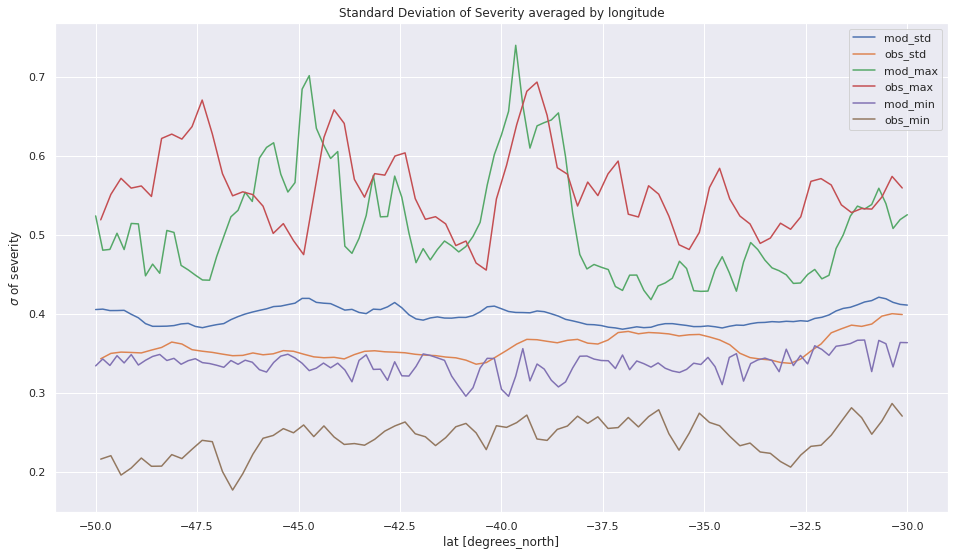

In [82]:
plt.plot(linspace(-50,-30, 115),  mean_mod_lat.data, label = 'mod_std');
mean_obs_lat.plot(label = 'obs_std');
plt.plot(linspace(-50,-30, 115),  max_mod_lat.data, label = 'mod_max');
max_obs_lat.plot(label = 'obs_max');
plt.plot(linspace(-50,-30, 115),  min_mod_lat.data, label = 'mod_min');
min_obs_lat.plot(label = 'obs_min');
plt.ylabel('$\sigma$ of severity')
plt.title('Standard Deviation of Severity averaged by longitude')
plt.legend();